In [12]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors



In [13]:
def read_json_file(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def extract_values_by_bin(data, key, num_bins):
    bin_values = [[] for _ in range(num_bins)]
    runtime = []
    for filename, phen_data in data.items():
        # if key not in phen_data:
        #     print(filename)
        for bin_data in phen_data[key]:
            bin_index = bin_data['index' if key == 'sigma' else 'bin']
            if bin_index < num_bins:
                bin_values[bin_index].append(bin_data[key])

        runtime.append(phen_data['runtime'])
    return bin_values, runtime

# def process_py_rhe_data(folder_path, num_files, num_bins):
#     py_rhe_sigma = [[] for _ in range(num_bins)]
#     py_rhe_h2 = [[] for _ in range(num_bins)]
#     py_rhe_enrichment = [[] for _ in range(num_bins)]
#     py_rhe_runtime = []

#     for i in range(num_files):
#         file_path = os.path.join(folder_path, f'output_{i}.json')
#         file_data = read_json_file(file_path)
#         for bin_index in range(num_bins):
#             py_rhe_sigma[bin_index].append(file_data['sigma_ests_total'][bin_index])
#             py_rhe_h2[bin_index].append(file_data['h2_total'][bin_index])
#             py_rhe_enrichment[bin_index].append(file_data['enrichment_total'][bin_index] if file_data['enrichment_total'] else 0)
#         py_rhe_runtime.append(file_data['runtime'])

#     return py_rhe_sigma, py_rhe_h2, py_rhe_enrichment, py_rhe_runtime

def read_json_from_txt(file_path):
    with open(file_path, 'r') as f:
        content = f.read()
        return json.loads(content)

def process_py_rhe_data(folder_path, num_bins):
    py_rhe_sigma = [[] for _ in range(num_bins)]
    py_rhe_h2 = [[] for _ in range(num_bins)]
    py_rhe_enrichment = [[] for _ in range(num_bins)]
    py_rhe_runtime = []

    total_file = []

    for root, dirs, files in os.walk(folder_path):
        print(sorted(files))
        for file in sorted(files):
            if file.endswith(".json"):
                total_file.append(file)
                file_path = os.path.join(root, file)
                file_data = read_json_from_txt(file_path)
                
                for bin_index in range(num_bins):
                    if 'sigma_ests_total' not in file_data:
                        print(file)
                    py_rhe_sigma[bin_index].append(file_data['sigma_ests_total'][bin_index])
                    py_rhe_h2[bin_index].append(file_data['h2_total'][bin_index])
                    enrichment = file_data.get('enrichment_total', [0] * num_bins)
                    py_rhe_enrichment[bin_index].append(enrichment[bin_index] if enrichment else 0)
                py_rhe_runtime.append(file_data['runtime'])

    return py_rhe_sigma, py_rhe_h2, py_rhe_enrichment, py_rhe_runtime, total_file






# def plot_comparison(ori_values, pyrhe_values, metric_name, bin_index):
#     plt.scatter(ori_values, pyrhe_values, label=f'Bin {bin_index + 1}')
#     max_value = max(max(ori_values), max(pyrhe_values))
#     min_value = min(min(ori_values), min(pyrhe_values))
#     plt.plot([min_value, max_value], [min_value, max_value], 'k--', label='y = x')
#     plt.xlabel('Original RHE output')
#     plt.ylabel('PyRHE output')
#     plt.title(f'{metric_name} Comparison for Bin {bin_index + 1}')
#     plt.legend()
#     plt.grid(True)
#     plt.axis('equal')

# def plot_metrics(ori_data, pyrhe_data, num_bins):
#     metrics = ['sigma', 'h2', 'enrichment']
#     for bin_index in range(num_bins):
#         plt.figure(figsize=(18, 5))
#         for i, metric in enumerate(metrics):
#             plt.subplot(1, 3, i+1)
#             plot_comparison(ori_data[metric][bin_index], pyrhe_data[metric][bin_index], metric.upper(), bin_index)
#         plt.tight_layout()
#         plt.show()



def plot_comparison(all_ori_values, all_pyrhe_values, metric_name):
    colors = list(mcolors.TABLEAU_COLORS)  
    for bin_index, (ori_values, pyrhe_values) in enumerate(zip(all_ori_values, all_pyrhe_values)):
        plt.scatter(ori_values, pyrhe_values, label=f'Bin {bin_index + 1}', color=colors[bin_index % len(colors)])
    
    max_value = max(max(max(vals) for vals in all_ori_values), max(max(vals) for vals in all_pyrhe_values))
    min_value = min(min(min(vals) for vals in all_ori_values), min(min(vals) for vals in all_pyrhe_values))
    plt.plot([min_value, max_value], [min_value, max_value], 'k--', label='y = x')

    plt.xlabel('Original RHE output')
    plt.ylabel('PyRHE output')
    plt.title(f'{metric_name} Comparison Across Bins')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')

def plot_metrics(ori_data, pyrhe_data, num_bins):
    plt.figure(figsize=(18, 6))

    metrics = ['sigma', 'h2', 'enrichment']
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        print(metric)
        print(pyrhe_data[metric][0])
        print(ori_data[metric][0])
        plot_comparison(ori_data[metric], pyrhe_data[metric], metric.upper())
    
    plt.tight_layout()
    plt.show()

def summarize_results(use_cov, num_bins, num_samples):
    cov = "cov" if use_cov else "no_cov"
    ori_file_path = f'/u/home/j/jiayini/project-sriram/PyRHE/results_300k/original_result/{cov}/bin_{num_bins}/summary.json'
    pyrhe_folder = f'/u/home/j/jiayini/project-sriram/PyRHE/results_300k/pyrhe_output/{cov}/bin_{num_bins}'

    ori_data = read_json_file(ori_file_path)
    pyrhe_sigma, pyrhe_h2, pyrhe_enrichment, pyrhe_runtime, total_file = process_py_rhe_data(pyrhe_folder, num_bins)
    pyrhe_sigma_formatted = [f"{number:.2f}" for number in pyrhe_enrichment[0]]
    print(pyrhe_sigma_formatted)
    print(len(pyrhe_sigma_formatted))
    ori_sigma_bins, ori_runtime = extract_values_by_bin(ori_data, 'sigma', num_bins)
    ori_sigma_formatted = [f"{number:.2f}" for number in pyrhe_enrichment[0]]
    print(ori_sigma_formatted)
    print(len(ori_sigma_formatted))

    indices_diff_big = [
        index for index, (a, b) in enumerate(zip(pyrhe_sigma[0], ori_sigma_bins[0])) if abs(a - b) > 0.1
    ]

    for index in indices_diff_big:
        print(total_file[index])



    ori_h2_bins, _ = extract_values_by_bin(ori_data, 'h2', num_bins)
    ori_enrichment_bins, _ = extract_values_by_bin(ori_data, 'enrichment', num_bins)

    if num_bins == 1 and not ori_enrichment_bins[0]:
        ori_enrichment_bins = [[1]]
    
    ori_data = {
        'sigma': ori_sigma_bins,
        'h2': ori_h2_bins,
        'enrichment': ori_enrichment_bins,
    }
    pyrhe_data = {
        'sigma': pyrhe_sigma,
        'h2': pyrhe_h2,
        'enrichment': pyrhe_enrichment,
    }
    plot_metrics(ori_data, pyrhe_data, num_bins)


['ala_at.json', 'albumin.json', 'alcohol_freq.json', 'alka_phos.json', 'apo_a.json', 'asp_at.json', 'basal_metabolic.json', 'blood_eosinophil.json', 'blood_lymphocyte.json', 'blood_mch.json', 'blood_monocyte.json', 'blood_mpv.json', 'blood_mscv.json', 'blood_platelet.json', 'blood_platelet_distrib_width.json', 'blood_rbc_count.json', 'blood_rbc_distrib_width.json', 'blood_reticulocyte.json', 'blood_wbc_count.json', 'bmd_heel_tscore.json', 'bmi.json', 'bp_diastolic.json', 'bp_systolic.json', 'c_reactive_prot.json', 'calcium.json', 'cholesterol.json', 'creatinine.json', 'creatinine_urine.json', 'cystatin_c.json', 'fev1_fvc.json', 'fvc.json', 'ggt.json', 'glucose.json', 'hba1c.json', 'hdl.json', 'height.json', 'igf1.json', 'ldl.json', 'microalbumin.json', 'overall_health.json', 'phosphate.json', 'potassium.json', 'shbg.json', 'sodium_urine.json', 'testosterone.json', 'triglycerides.json', 'urate.json', 'urea.json', 'vitamin_d.R.json', 'whr.json']
['1.00', '1.00', '1.00', '1.00', '1.00', '

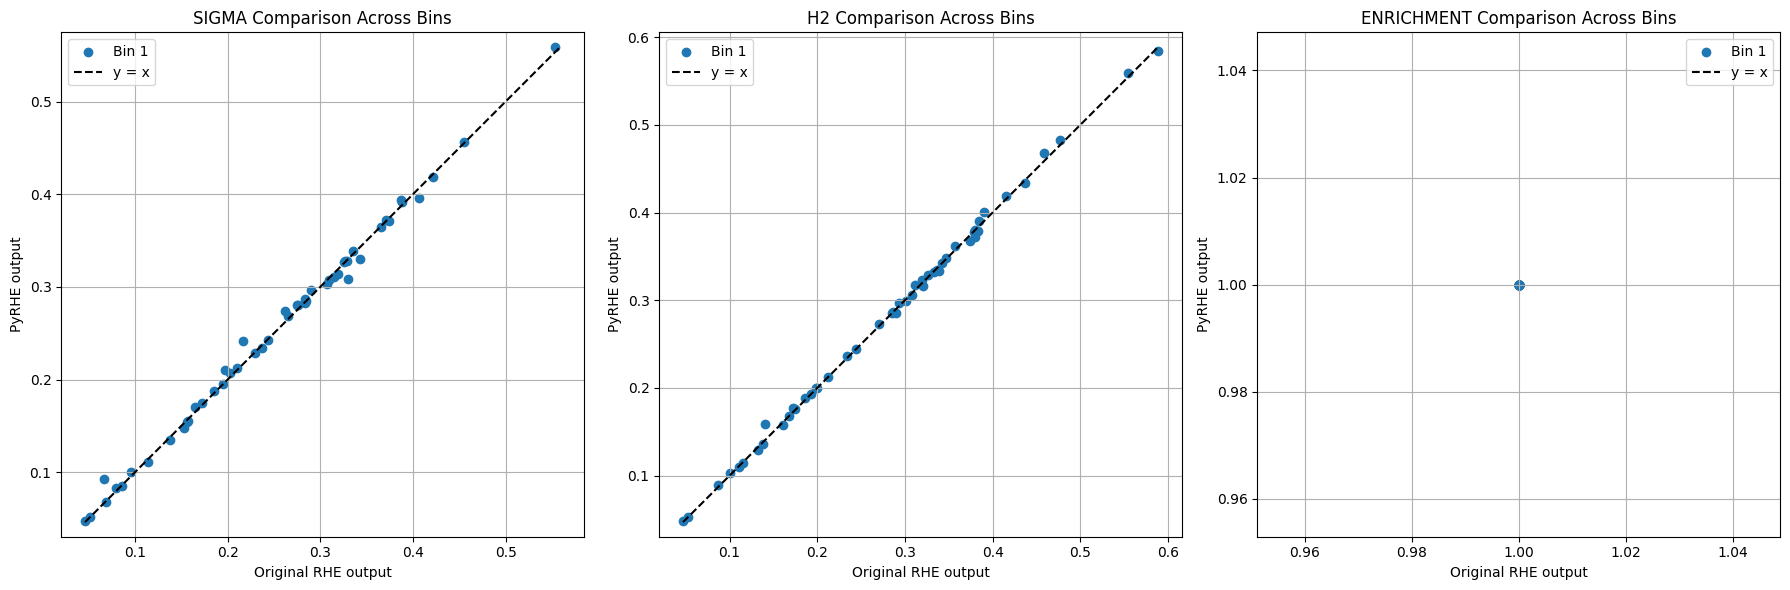

In [14]:
summarize_results(True, 1, 50)


['ala_at.json', 'albumin.json', 'alcohol_freq.json', 'alka_phos.json', 'apo_a.json', 'asp_at.json', 'basal_metabolic.json', 'blood_eosinophil.json', 'blood_lymphocyte.json', 'blood_mch.json', 'blood_monocyte.json', 'blood_mpv.json', 'blood_mscv.json', 'blood_platelet.json', 'blood_platelet_distrib_width.json', 'blood_rbc_count.json', 'blood_rbc_distrib_width.json', 'blood_reticulocyte.json', 'blood_wbc_count.json', 'bmd_heel_tscore.json', 'bmi.json', 'bp_diastolic.json', 'bp_systolic.json', 'c_reactive_prot.json', 'calcium.json', 'cholesterol.json', 'creatinine.json', 'creatinine_urine.json', 'cystatin_c.json', 'fev1_fvc.json', 'fvc.json', 'ggt.json', 'glucose.json', 'hba1c.json', 'hdl.json', 'height.json', 'igf1.json', 'ldl.json', 'microalbumin.json', 'overall_health.json', 'phosphate.json', 'potassium.json', 'shbg.json', 'sodium_urine.json', 'testosterone.json', 'triglycerides.json', 'urate.json', 'urea.json', 'vitamin_d.R.json', 'whr.json']
['0.45', '0.47', '0.42', '0.43', '0.36', '

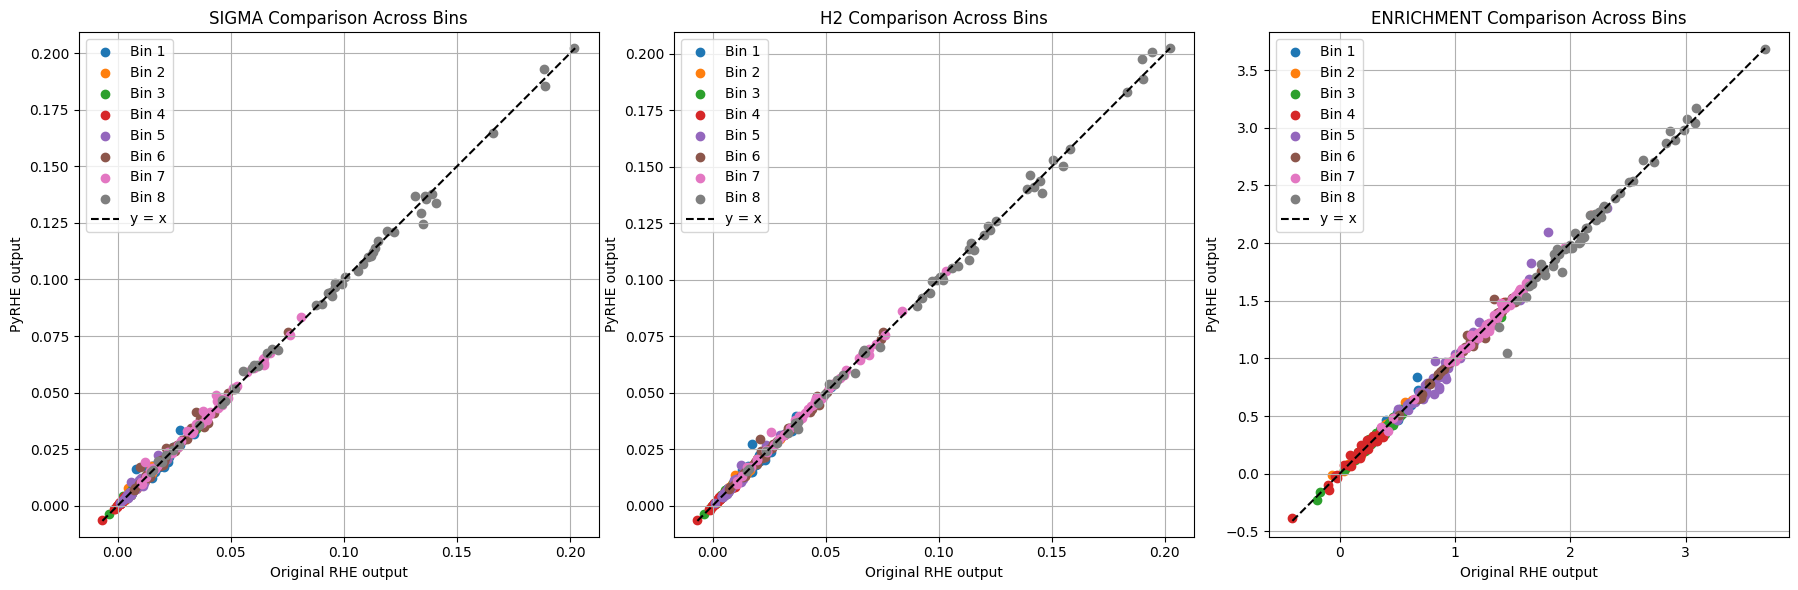

In [15]:
summarize_results(True, 8, 50)
